Please run those two cells before running the Notebook!

As those plotting settings are standard throughout the book, we do not show them in the book every time we plot something.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

# Chapter 8 - Multi-Factor Models

## 8.1 Estimating the CAPM

### How to do it...

1. Import the libraries:

In [3]:
import pandas as pd
import yfinance as yf
import statsmodels.api as sm

2. Specify the risky asset, the benchmark, and the time horizon:

In [4]:
RISKY_ASSET = "AMZN"
MARKET_BENCHMARK = "^GSPC"
START_DATE = "2016-01-01"
END_DATE = "2020-12-31"

3. Download data from Yahoo Finance:

In [5]:
df = yf.download([RISKY_ASSET, MARKET_BENCHMARK],
                 start=START_DATE,
                 end=END_DATE,
                 progress=False)

print(f'Downloaded {df.shape[0]} rows of data.')

Downloaded 1258 rows of data.


4. Resample to monthly data and calculate simple returns:

In [6]:
X = (
    df["Adj Close"]
    .rename(columns={RISKY_ASSET: "asset", 
                     MARKET_BENCHMARK: "market"})
    .resample("M")
    .last()
    .pct_change()
    .dropna()
)
X.head()

Ticker,asset,market
Date,,
2016-02-29,-0.058739,-0.004128
2016-03-31,0.074423,0.065991
2016-04-30,0.111094,0.002699
2016-05-31,0.095817,0.015325
2016-06-30,-0.009920,0.000911


5. Calculate beta using the covariance approach: 

In [7]:
covariance = X.cov().iloc[0,1]
benchmark_variance = X.market.var()
beta = covariance / benchmark_variance
beta

1.1537107874315524

6. Prepare the input and estimate CAPM as a linear regression:

In [8]:
# separate target
y = X.pop("asset")

# add constant
X = sm.add_constant(X)

# define and fit the regression model 
capm_model = sm.OLS(y, X).fit()

# print results 
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     36.15
Date:                Thu, 22 Feb 2024   Prob (F-statistic):           1.37e-07
Time:                        17:46:43   Log-Likelihood:                 79.803
No. Observations:                  59   AIC:                            -155.6
Df Residuals:                      57   BIC:                            -151.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.009      2.182      0.0

Or, using the formula notation:

In [9]:
import statsmodels.formula.api as smf

# rerun step 4 to have a DF with columns: `asset` and `market`
X = df["Adj Close"].rename(columns={RISKY_ASSET: "asset", 
                                    MARKET_BENCHMARK: "market"}) \
                   .resample("M") \
                   .last() \
                   .pct_change() \
                   .dropna()

# define and fit the regression model 
capm_model = smf.ols(formula="asset ~ market", data=X).fit()

# print results 
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     36.15
Date:                Thu, 22 Feb 2024   Prob (F-statistic):           1.37e-07
Time:                        17:46:43   Log-Likelihood:                 79.803
No. Observations:                  59   AIC:                            -155.6
Df Residuals:                      57   BIC:                            -151.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0188      0.009      2.182      0.0

### There's more

#### Risk-free rate (13 Week Treasury Bill)

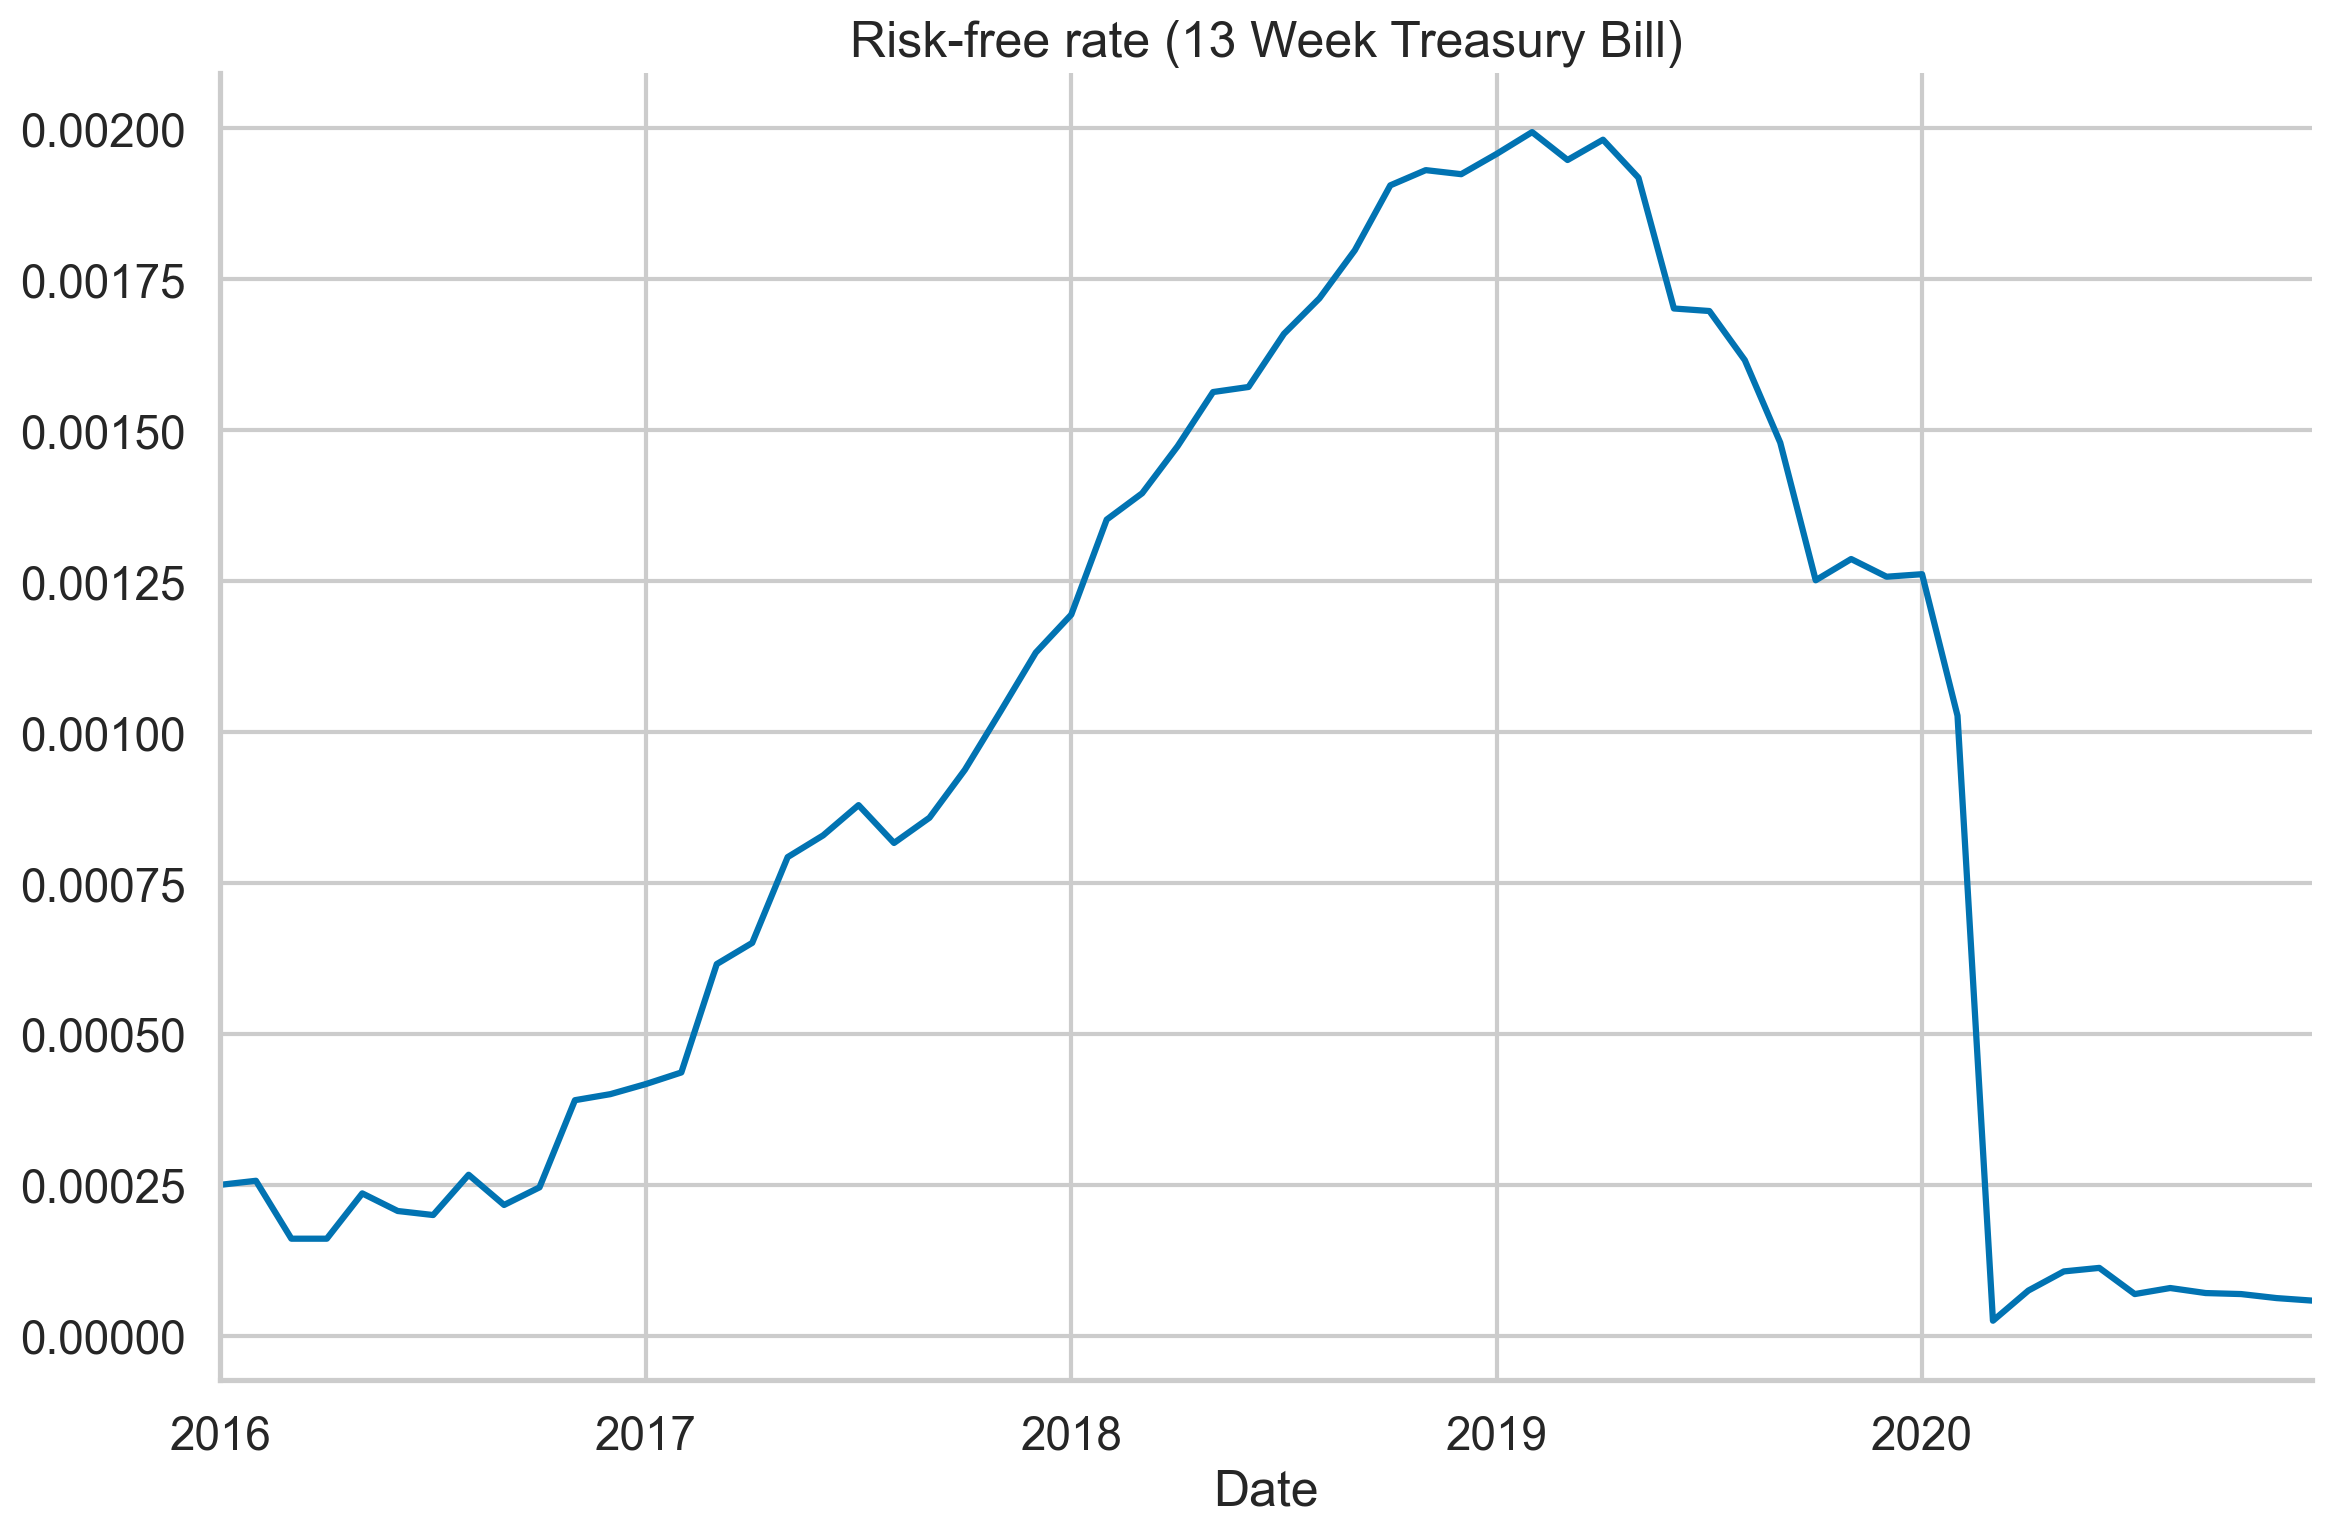

In [10]:
# period length in days
N_DAYS = 90

# download data from Yahoo finance
df_rf = yf.download("^IRX",
                    start=START_DATE,
                    end=END_DATE,
                    progress=False)

# resample to monthly by taking last value from each month
rf = df_rf.resample("M").last().Close / 100

# calculate the corresponding daily risk-free return  
rf = ( 1 / (1 - rf * N_DAYS / 360) )**(1 / N_DAYS)  

# convert to monthly and subtract 1
rf = (rf ** 30) - 1 

# plot the risk-free rate
rf.plot(title="Risk-free rate (13 Week Treasury Bill)")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_9_2", dpi=200)

#### Risk-free rate (3-Month Treasury Bill)

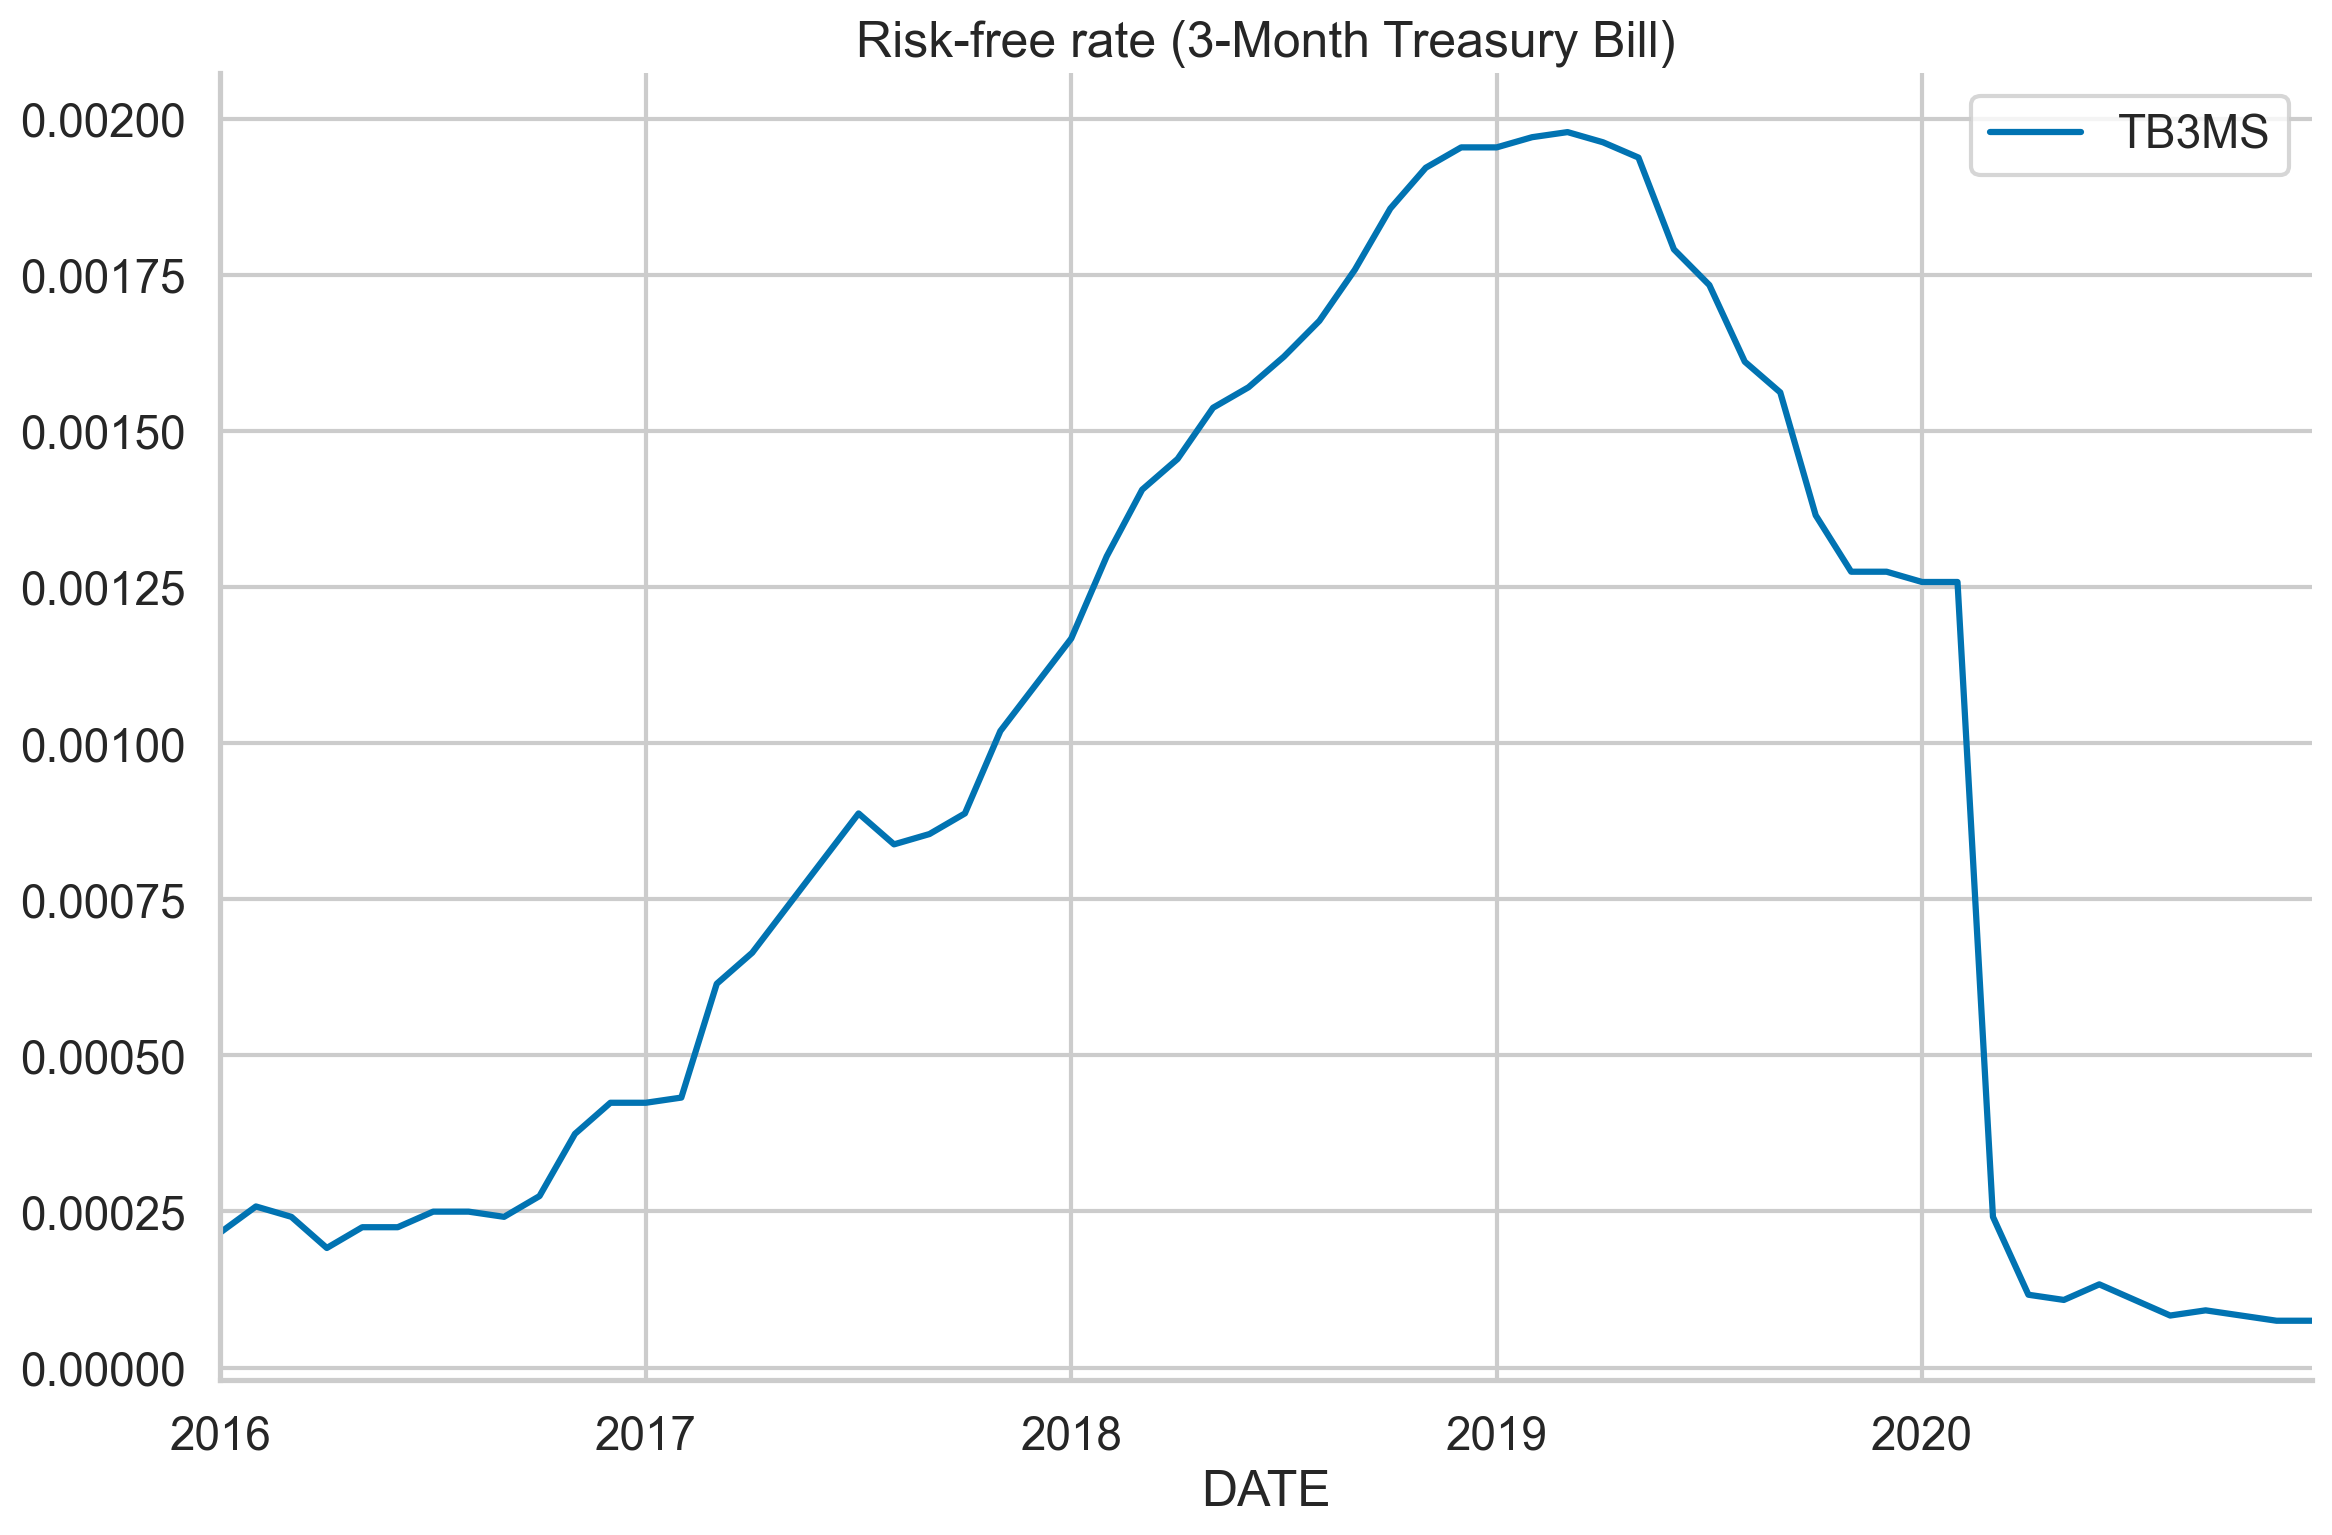

In [11]:
import pandas_datareader.data as web

# download the data 
rf = web.DataReader(
    "TB3MS", "fred", start=START_DATE, end=END_DATE
)

# convert to monthly
rf = (1 + (rf / 100)) ** (1 / 12) - 1

# plot the risk-free rate
rf.plot(title="Risk-free rate (3-Month Treasury Bill)")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_9_3", dpi=200)

## 8.2 Estimating the Fama-French three-factor model

### How to do it...

1. Import the libraries:

In [12]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

2. Define parameters:

In [13]:
RISKY_ASSET = "AAPL"
START_DATE = "2016-01-01"
END_DATE = "2020-12-31"

3. Download the dataset containing the risk factors:

In [14]:
ff_dict = web.DataReader("F-F_Research_Data_Factors", 
                         "famafrench", 
                         start=START_DATE,
                         end=END_DATE)

In [15]:
ff_dict.keys()

dict_keys([0, 1, 'DESCR'])

In [16]:
print(ff_dict['DESCR'])

F-F Research Data Factors
-------------------------

This file was created by CMPT_ME_BEME_RETS using the 202312 CRSP database. The 1-month TBill return is from Ibbotson and Associates, Inc. Copyright 2023 Kenneth R. French

  0 : (60 rows x 4 cols)
  1 : Annual Factors: January-December (5 rows x 4 cols)


4. Select the appropriate dataset and divide the values by 100:

In [17]:
factor_3_df = ff_dict[0].rename(columns={"Mkt-RF": "MKT"}) \
                        .div(100)

factor_3_df.head()

,MKT,SMB,HML,RF
Date,,,,
2016-01,-0.0577,-0.0342,0.0209,0.0001
2016-02,-0.0007,0.0073,-0.0057,0.0002
2016-03,0.0696,0.0082,0.0119,0.0002
2016-04,0.0091,0.0076,0.0328,0.0001
2016-05,0.0178,-0.0017,-0.0166,0.0001


5. Download the prices of the risky asset:

In [18]:
asset_df = yf.download(RISKY_ASSET,
                       start=START_DATE,
                       end=END_DATE,
                       progress=False)

print(f"Downloaded {asset_df.shape[0]} rows of data.")

Downloaded 1258 rows of data.


6. Calculate monthly returns on the risky asset:

In [19]:
y = asset_df["Adj Close"].resample("M") \
                         .last() \
                         .pct_change() \
                         .dropna()

y.index = y.index.to_period("m")
y.name = "rtn"
y.head()

Date
2016-02   -0.001288
2016-03    0.127211
2016-04   -0.139921
2016-05    0.071773
2016-06   -0.042659
Freq: M, Name: rtn, dtype: float64

7. Merge the datasets and calculate excess returns:

In [20]:
factor_3_df = factor_3_df.join(y)
factor_3_df["excess_rtn"] = (
    factor_3_df["rtn"] - factor_3_df["RF"]
)
factor_3_df.head()

,MKT,SMB,HML,RF,rtn,excess_rtn
Date,,,,,,
2016-01,-0.0577,-0.0342,0.0209,0.0001,NaN,NaN
2016-02,-0.0007,0.0073,-0.0057,0.0002,-0.001288,-0.001488
2016-03,0.0696,0.0082,0.0119,0.0002,0.127211,0.127011
2016-04,0.0091,0.0076,0.0328,0.0001,-0.139921,-0.140021
2016-05,0.0178,-0.0017,-0.0166,0.0001,0.071773,0.071673


8. Estimate the three-factor model:

In [21]:
# define and fit the regression model 
ff_model = smf.ols(formula="excess_rtn ~ MKT + SMB + HML", 
                   data=factor_3_df).fit()

# print results 
print(ff_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     17.86
Date:                Thu, 22 Feb 2024   Prob (F-statistic):           3.22e-08
Time:                        17:46:48   Log-Likelihood:                 80.978
No. Observations:                  59   AIC:                            -154.0
Df Residuals:                      55   BIC:                            -145.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0085      0.009      0.930      0.3

Print available datasets (here only first 5):

In [22]:
from pandas_datareader.famafrench import get_available_datasets

get_available_datasets()[:5]

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily']

## 8.3 Estimating the rolling three-factor model on a portfolio of assets

### How to do it...

1. Import the libraries:

In [23]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

2. Define the parameters:

In [24]:
ASSETS = ["AMZN", "GOOG", "AAPL", "MSFT"]
WEIGHTS = [0.25, 0.25, 0.25, 0.25]
START_DATE = "2010-01-01"
END_DATE = "2020-12-31"

3. Download the factor related data:

In [25]:
factor_3_df = web.DataReader("F-F_Research_Data_Factors", 
                             "famafrench", 
                             start=START_DATE,
                             end=END_DATE)[0]
factor_3_df = factor_3_df.div(100)

4. Download the prices of risky assets from Yahoo Finance:

In [26]:
asset_df = yf.download(ASSETS,
                       start=START_DATE,
                       end=END_DATE,
                       progress=False)

print(f"Downloaded {asset_df.shape[0]} rows of data.")

Downloaded 2768 rows of data.


5. Calculate the monthly returns on the risky assets:

In [27]:
asset_df = asset_df["Adj Close"].resample("M") \
                                .last() \
                                .pct_change() \
                                .dropna()
# reformat index for joining
asset_df.index = asset_df.index.to_period("m")

6. Calculate the portfolio returns:

In [28]:
asset_df["portfolio_returns"] = np.matmul(
    asset_df[ASSETS].values, 
    WEIGHTS
)
asset_df.head()

Ticker,AAPL,AMZN,GOOG,MSFT,portfolio_returns
Date,,,,,
2010-02,0.065397,-0.055897,-0.005925,0.022146,0.006430
2010-03,0.148470,0.146706,0.076538,0.021625,0.098335
2010-04,0.111022,0.009796,-0.073036,0.042677,0.022615
2010-05,-0.016125,-0.084902,-0.076222,-0.151395,-0.082161
2010-06,-0.020827,-0.129125,-0.083768,-0.108139,-0.085465


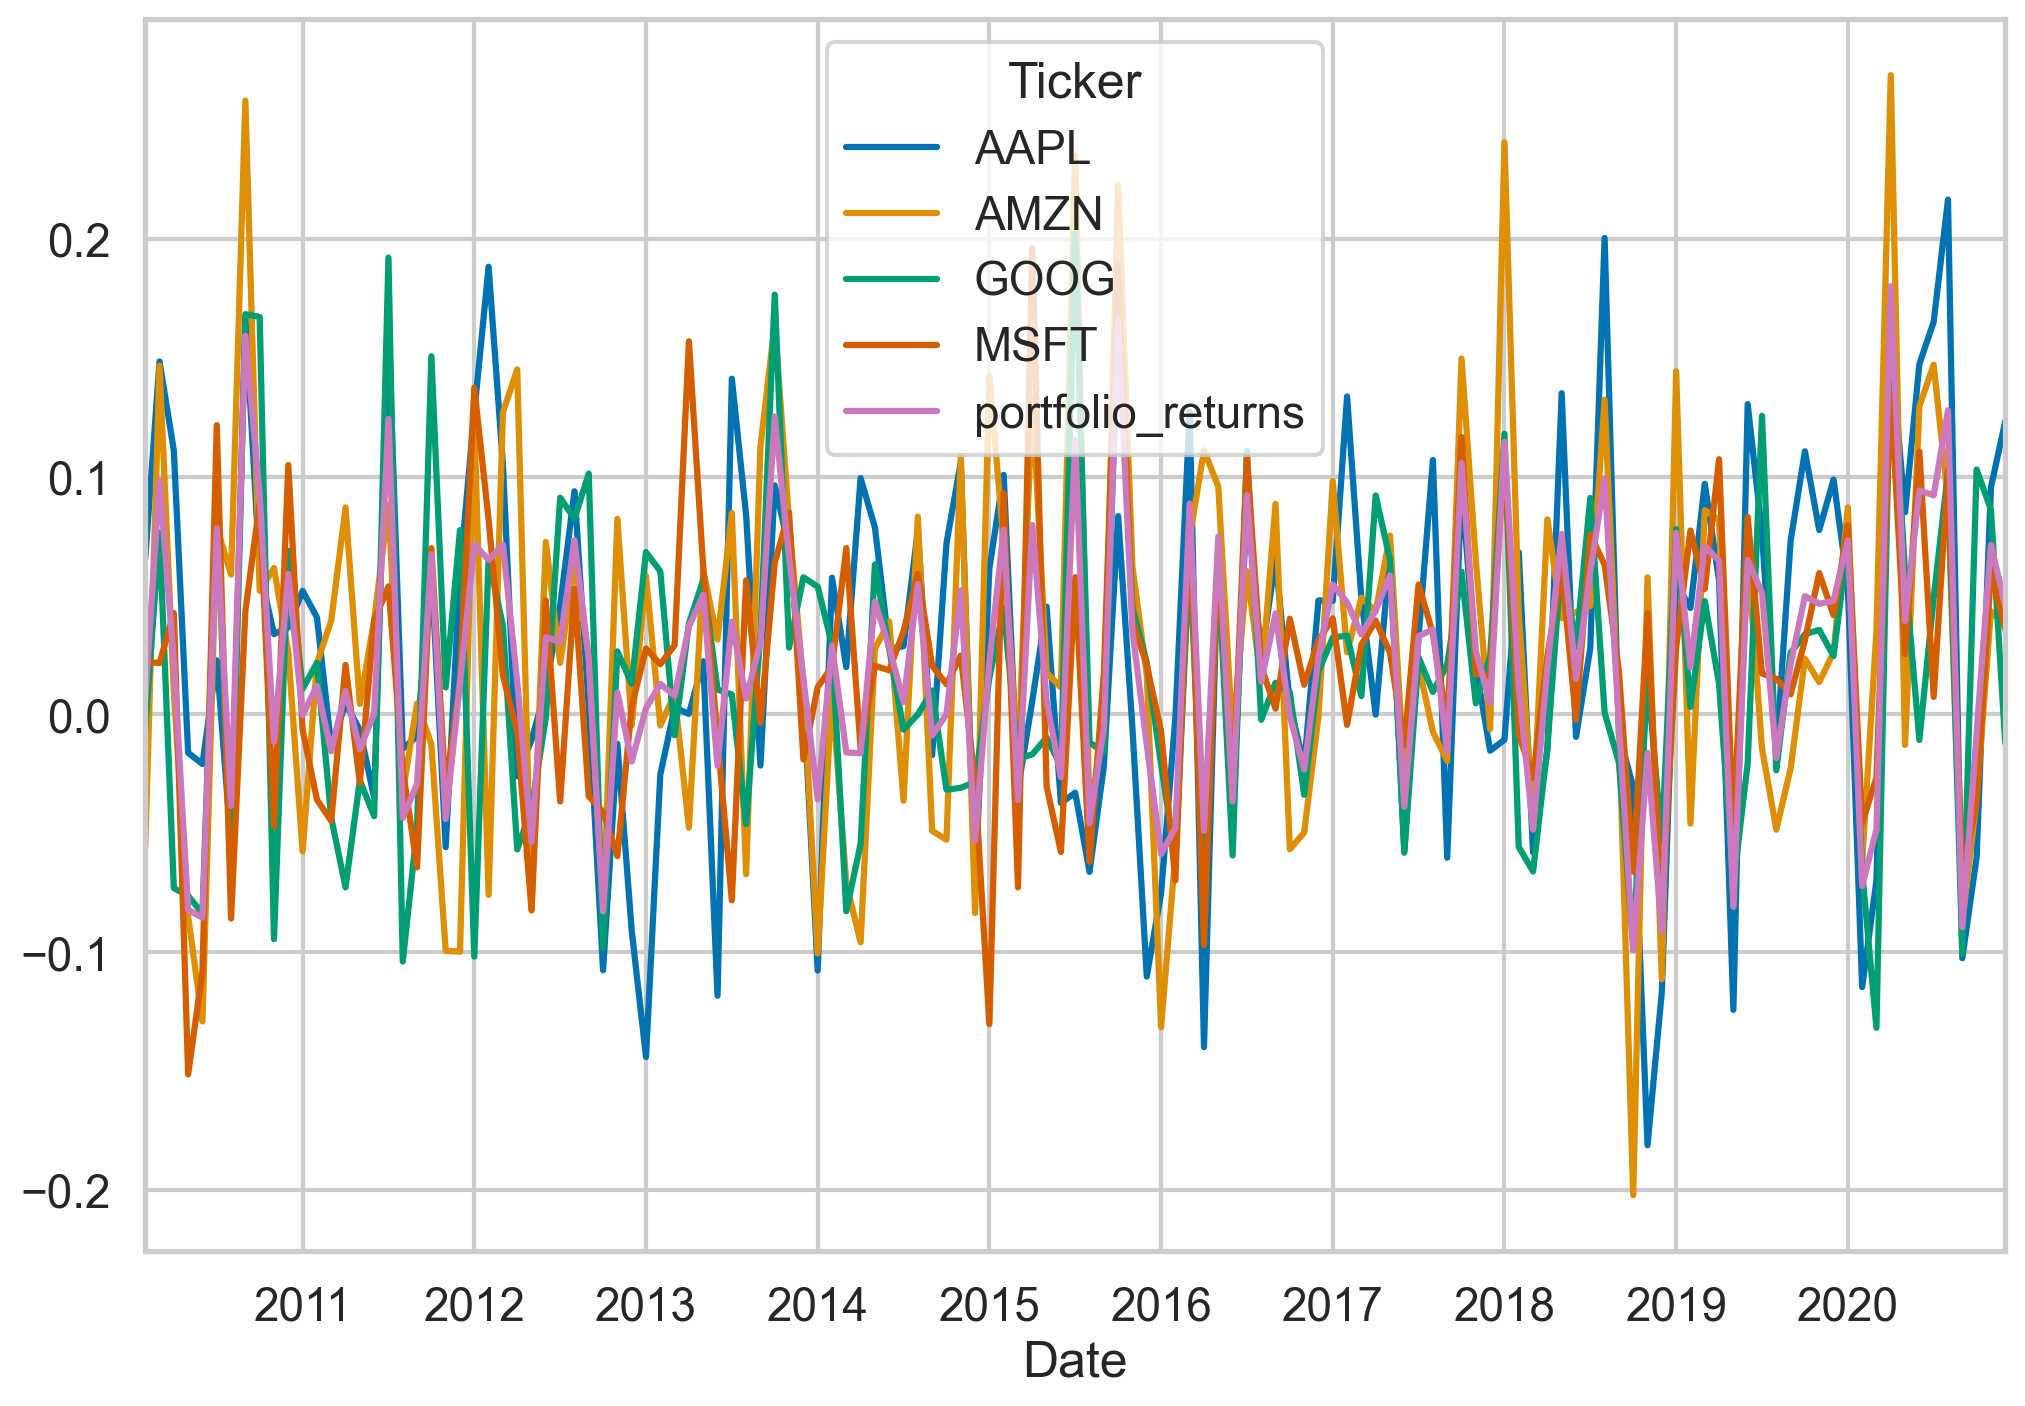

In [29]:
asset_df.plot();

7. Merge the datasets:

In [30]:
factor_3_df = asset_df.join(factor_3_df).drop(ASSETS, axis=1)
factor_3_df.columns = ["portf_rtn", "mkt", "smb", "hml", "rf"]
factor_3_df["portf_ex_rtn"] = (
    factor_3_df["portf_rtn"] - factor_3_df["rf"]
)

8. Define a function for the rolling n-factor model

In [31]:
def rolling_factor_model(input_data, formula, window_size):
    """
    Function for estimating the Fama-French (n-factor) model using a rolling window of fixed size.
    
    Parameters
    ------------
    input_data : pd.DataFrame
        A DataFrame containing the factors and asset/portfolio returns
    formula : str
        `statsmodels` compatible formula representing the OLS regression  
    window_size : int
        Rolling window length.
    
    Returns
    -----------
    coeffs_df : pd.DataFrame
        DataFrame containing the intercept and the three factors for each iteration.
    """

    coeffs = []

    for start_ind in range(len(input_data) - window_size + 1):        
        end_ind = start_ind + window_size

        # define and fit the regression model 
        ff_model = smf.ols(
            formula=formula, 
            data=input_data[start_ind:end_ind]
        ).fit()
   
        # store coefficients
        coeffs.append(ff_model.params)
    
    coeffs_df = pd.DataFrame(
        coeffs, 
        index=input_data.index[window_size - 1:]
    )

    return coeffs_df

9. Estimate the rolling three-factor model and plot the results:

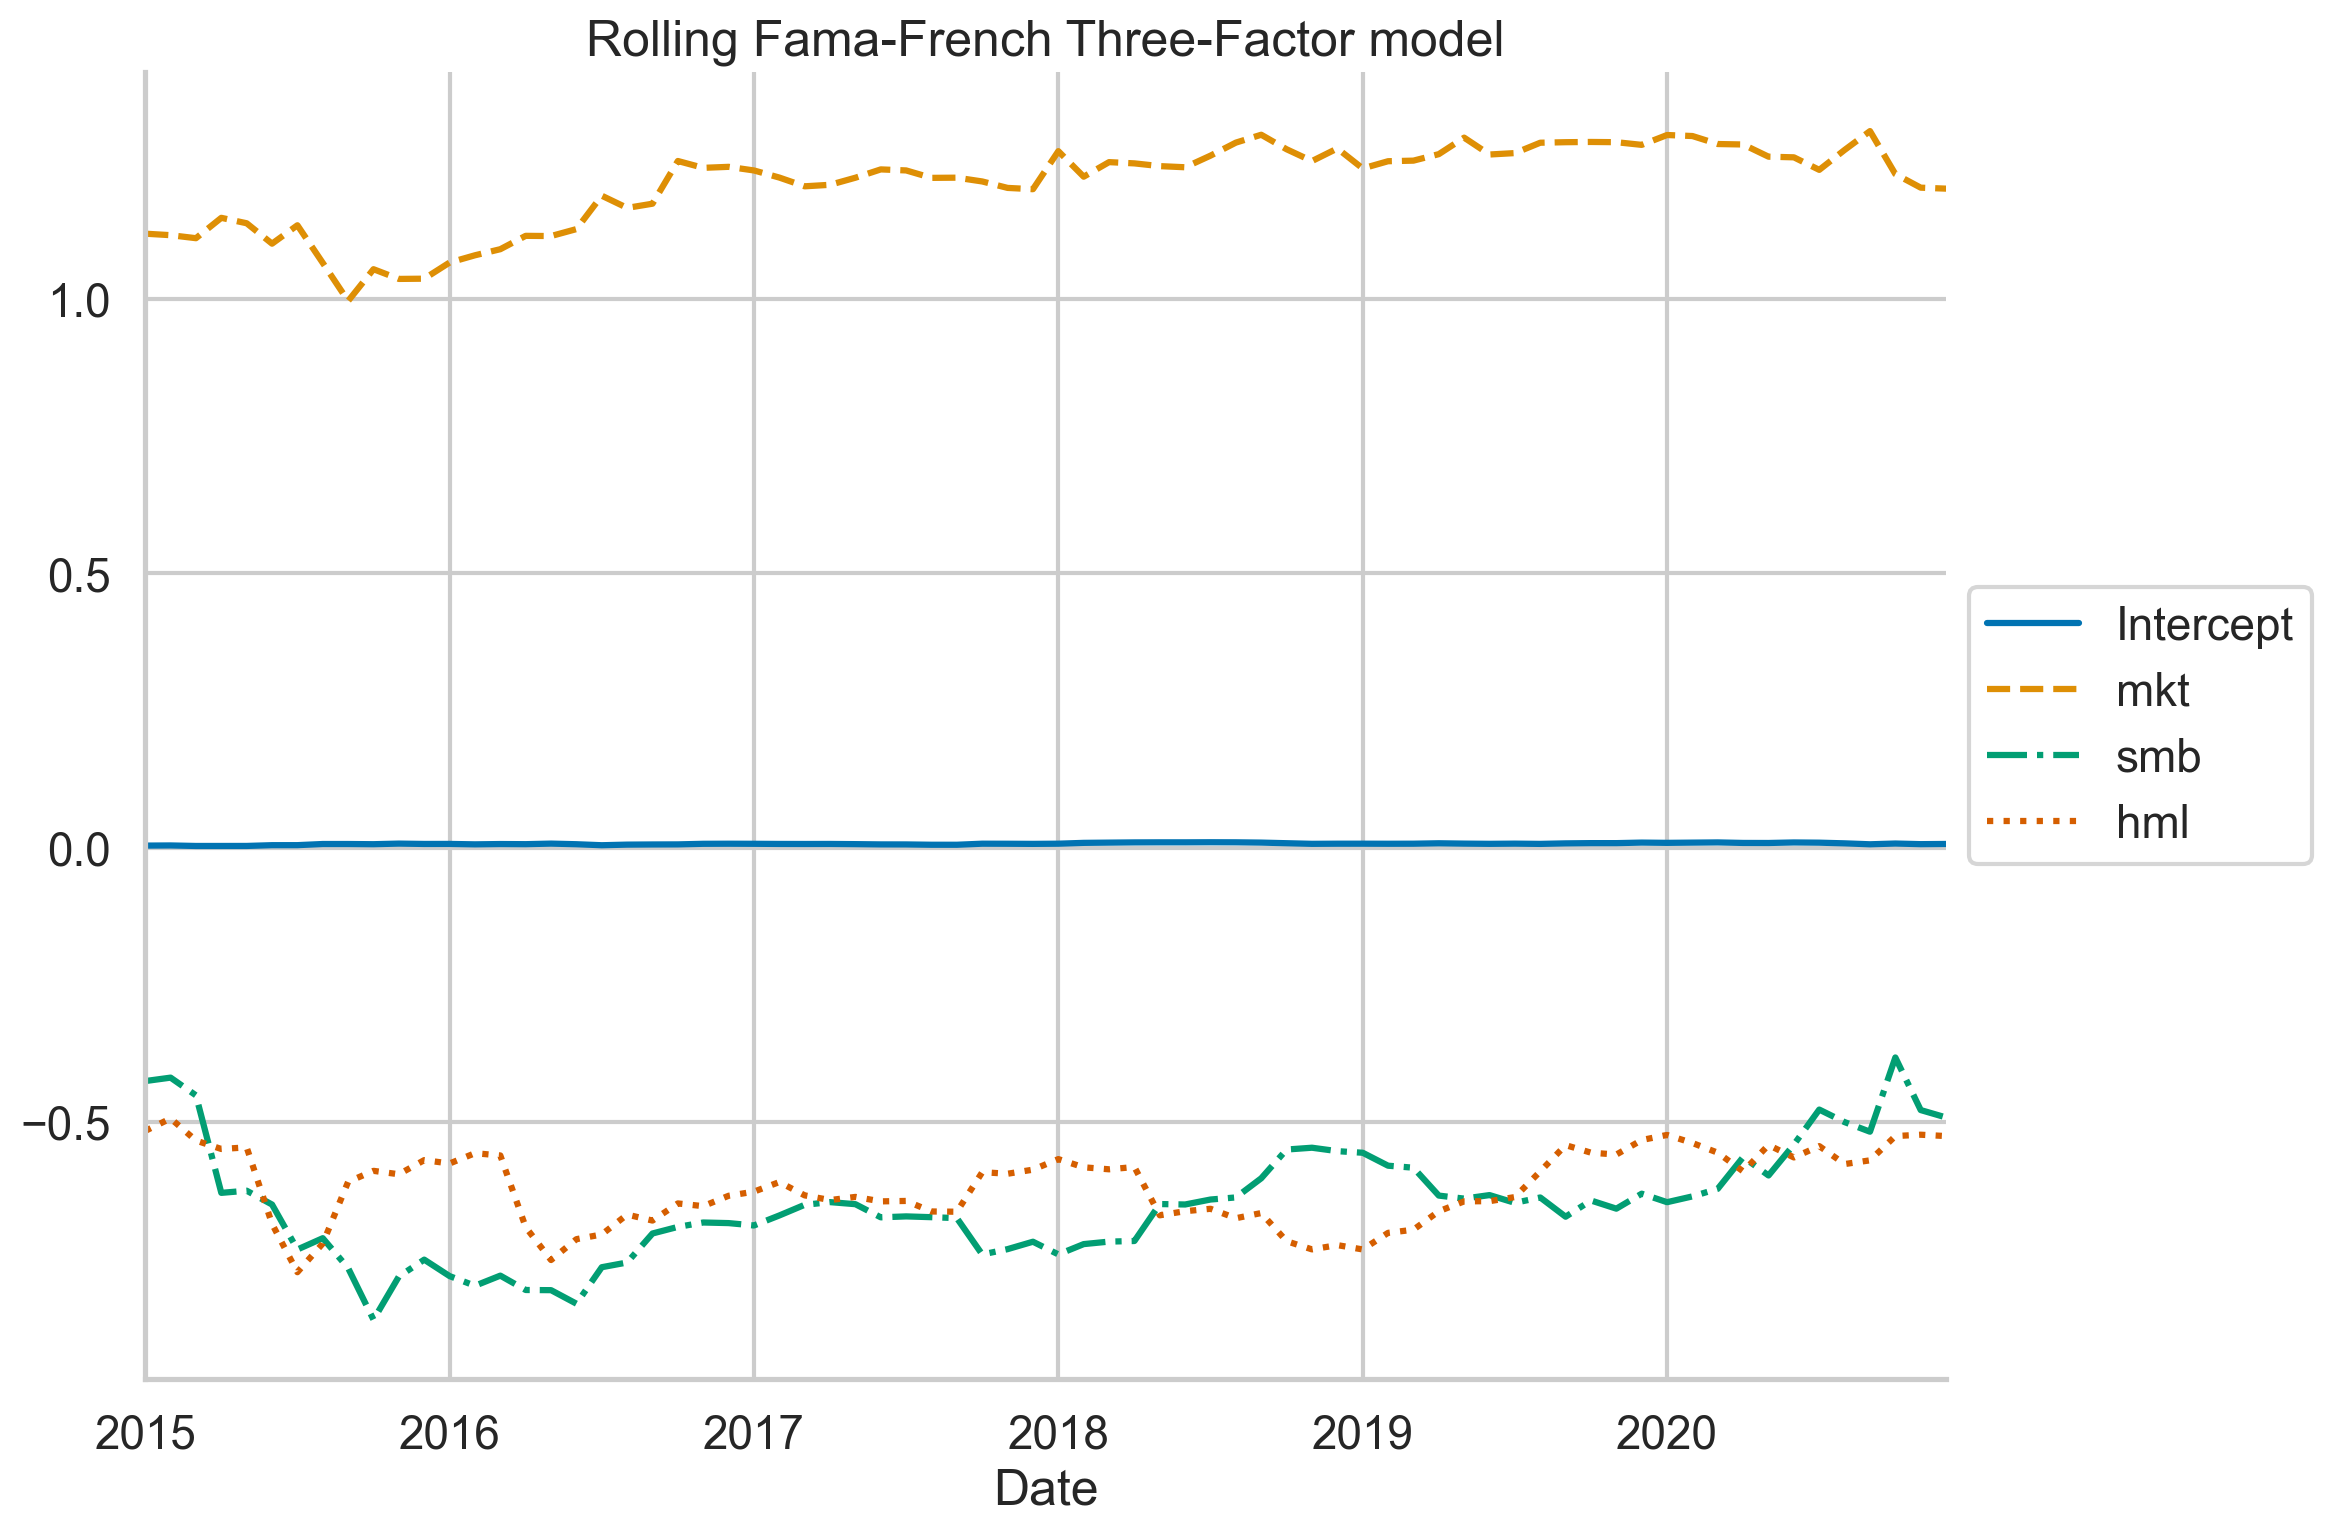

In [32]:
MODEL_FORMULA = "portf_ex_rtn ~ mkt + smb + hml"
results_df = rolling_factor_model(factor_3_df, 
                                  MODEL_FORMULA, 
                                  window_size=60)
(
    results_df
    .plot(title = "Rolling Fama-French Three-Factor model",
          style=["-", "--", "-.", ":"])
    .legend(loc="center left",bbox_to_anchor=(1.0, 0.5))
)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_9_6", dpi=200)

## 8.4 Estimating the four- and five-factor models

### How to do it...

1. Import the libraries:

In [33]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

2. Specify the risky asset and the time horizon:

In [34]:
RISKY_ASSET = "AMZN"
START_DATE = "2016-01-01"
END_DATE = "2020-12-31"

3. Download the risk factors from prof. French's website:

In [35]:
# three factors 
factor_3_df = web.DataReader("F-F_Research_Data_Factors", 
                             "famafrench", 
                             start=START_DATE,
                             end=END_DATE)[0]

# momentum factor
momentum_df = web.DataReader("F-F_Momentum_Factor", 
                             "famafrench", 
                             start=START_DATE,
                             end=END_DATE)[0]
      
# five factors
factor_5_df = web.DataReader("F-F_Research_Data_5_Factors_2x3", 
                             "famafrench", 
                             start=START_DATE,
                             end=END_DATE)[0]

4. Download the data of the risky asset from Yahoo Finance:

In [36]:
asset_df = yf.download(RISKY_ASSET,
                       start=START_DATE,
                       end=END_DATE,
                       progress=False)

print(f"Downloaded {asset_df.shape[0]} rows of data.")

Downloaded 1258 rows of data.


5. Calculate monthly returns:

In [37]:
y = asset_df["Adj Close"].resample("M") \
                         .last() \
                         .pct_change() \
                         .dropna()

y.index = y.index.to_period("m")
y.name = "rtn"

6. Merge the datasets for the four-factor models:

In [38]:
# join all datasets on the index
factor_4_df = factor_3_df.join(momentum_df).join(y)

# rename columns
factor_4_df.columns = ["mkt", "smb", "hml", "rf", "mom", "rtn"]

# divide everything (except returns) by 100
factor_4_df.loc[:, factor_4_df.columns != "rtn"] /= 100

# calculate excess returns
factor_4_df["excess_rtn"] = (
    factor_4_df["rtn"] - factor_4_df["rf"]
)

factor_4_df.head()

,mkt,smb,hml,rf,mom,rtn,excess_rtn
Date,,,,,,,
2016-01,-0.0577,-0.0342,0.0209,0.0001,0.0144,NaN,NaN
2016-02,-0.0007,0.0073,-0.0057,0.0002,-0.0438,-0.058739,-0.058939
2016-03,0.0696,0.0082,0.0119,0.0002,-0.0501,0.074423,0.074223
2016-04,0.0091,0.0076,0.0328,0.0001,-0.0602,0.111094,0.110994
2016-05,0.0178,-0.0017,-0.0166,0.0001,0.0142,0.095817,0.095717


7. Merge the datasets for the five-factor models:

In [39]:
# join all datasets on the index
factor_5_df = factor_5_df.join(y)

# rename columns
factor_5_df.columns = [
    "mkt", "smb", "hml", "rmw", "cma", "rf", "rtn"
]

# divide everything (except returns) by 100
factor_5_df.loc[:, factor_5_df.columns != "rtn"] /= 100

# calculate excess returns
factor_5_df["excess_rtn"] = (
    factor_5_df["rtn"] - factor_5_df["rf"]
)

factor_5_df.head()

,mkt,smb,hml,rmw,cma,rf,rtn,excess_rtn
Date,,,,,,,,
2016-01,-0.0577,-0.0347,0.0209,0.0282,0.0308,0.0001,NaN,NaN
2016-02,-0.0007,0.0088,-0.0057,0.0325,0.0202,0.0002,-0.058739,-0.058939
2016-03,0.0696,0.0107,0.0119,0.0077,-0.0008,0.0002,0.074423,0.074223
2016-04,0.0091,0.0123,0.0328,-0.0297,0.0190,0.0001,0.111094,0.110994
2016-05,0.0178,-0.0061,-0.0166,-0.0109,-0.0248,0.0001,0.095817,0.095717


8. Estimate the four-factor model:

In [40]:
four_factor_model = smf.ols(
    formula="excess_rtn ~ mkt + smb + hml + mom", 
    data=factor_4_df
).fit()

print(four_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     15.98
Date:                Thu, 22 Feb 2024   Prob (F-statistic):           1.08e-08
Time:                        17:46:56   Log-Likelihood:                 88.265
No. Observations:                  59   AIC:                            -166.5
Df Residuals:                      54   BIC:                            -156.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0073      0.008      0.898      0.3

9. Estimate the five-factor model:

In [41]:
five_factor_model = smf.ols(
    formula="excess_rtn ~ mkt + smb + hml + rmw + cma", 
    data=factor_5_df
).fit()

print(five_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     14.98
Date:                Thu, 22 Feb 2024   Prob (F-statistic):           3.73e-09
Time:                        17:46:56   Log-Likelihood:                 91.206
No. Observations:                  59   AIC:                            -170.4
Df Residuals:                      53   BIC:                            -157.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0067      0.008      0.856      0.3

## 8.5 Estimating cross-sectional factor models using the Fama-MacBeth regression

### How to do it...

1. Import the libraries:

In [42]:
import pandas as pd
import pandas_datareader.data as web
from linearmodels.asset_pricing import LinearFactorModel

2. Specify the time horizon:

In [43]:
START_DATE = "2010"
END_DATE = "2020-12"

3. Download and adjust the risk factors from prof. French's website:

In [44]:
factor_5_df = (
    web.DataReader("F-F_Research_Data_5_Factors_2x3", 
                   "famafrench", 
                   start=START_DATE, 
                   end=END_DATE)[0]
    .div(100)
)
factor_5_df.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2010-01,-0.0336,0.0034,0.0043,-0.0127,0.0046,0.0000
2010-02,0.0340,0.0151,0.0323,-0.0027,0.0143,0.0000
2010-03,0.0631,0.0185,0.0221,-0.0065,0.0169,0.0001
2010-04,0.0200,0.0498,0.0289,0.0069,0.0172,0.0001
2010-05,-0.0789,0.0004,-0.0244,0.0130,-0.0021,0.0001


4. Download and adjust the returns of 12 Industry Portfolios from prof. French's website:

In [45]:
portfolio_df = (
    web.DataReader("12_Industry_Portfolios", 
                   "famafrench", 
                   start=START_DATE, 
                   end=END_DATE)[0]
    .div(100)
    .sub(factor_5_df["RF"], axis=0)
)
portfolio_df.head()

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
Date,,,,,,,,,,,,
2010-01,-0.0240,-0.0043,-0.0446,-0.0484,-0.0117,-0.0791,-0.0672,-0.0444,-0.0184,-0.0002,-0.0065,-0.0030
2010-02,0.0266,0.0739,0.0585,0.0261,0.0404,0.0485,0.0276,-0.0042,0.0430,0.0038,0.0291,0.0475
2010-03,0.0588,0.0934,0.0782,0.0322,0.0408,0.0667,0.0762,0.0311,0.0625,0.0362,0.0830,0.0778
2010-04,-0.0103,0.0725,0.0415,0.0404,0.0131,0.0229,0.0340,0.0284,0.0254,-0.0219,0.0112,0.0290
2010-05,-0.0574,-0.0907,-0.0926,-0.1028,-0.0679,-0.0780,-0.0587,-0.0630,-0.0537,-0.0807,-0.0911,-0.0821


5. Drop the risk-free rate from the factor data set:

In [46]:
factor_5_df = factor_5_df.drop("RF", axis=1)
factor_5_df.head()

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2010-01,-0.0336,0.0034,0.0043,-0.0127,0.0046
2010-02,0.0340,0.0151,0.0323,-0.0027,0.0143
2010-03,0.0631,0.0185,0.0221,-0.0065,0.0169
2010-04,0.0200,0.0498,0.0289,0.0069,0.0172
2010-05,-0.0789,0.0004,-0.0244,0.0130,-0.0021


6. Estimate the Fama-MacBeth regression and print the summary:

In [47]:
five_factor_model = LinearFactorModel(
    portfolios=portfolio_df, 
    factors=factor_5_df
)
result = five_factor_model.fit()
print(result)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 12   R-squared:                      0.7884
No. Factors:                          5   J-statistic:                    10.120
No. Observations:                   132   P-value                         0.1819
Date:                  Thu, Feb 22 2024   Distribution:                  chi2(7)
Time:                          17:47:00                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         0.0123     0.0038     3.2608     0.0011      0.0049      0.0197
SMB           -0.0063     0.0052    

We can also print the full summary (1 aggregate and 12 individual ones for each portfolio separately).

In [48]:
print(result.full_summary)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 12   R-squared:                      0.7884
No. Factors:                          5   J-statistic:                    10.120
No. Observations:                   132   P-value                         0.1819
Date:                  Thu, Feb 22 2024   Distribution:                  chi2(7)
Time:                          17:47:00                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         0.0123     0.0038     3.2608     0.0011      0.0049      0.0197
SMB           -0.0063     0.0052    

### There's more

1. Import the libraries:

In [49]:
from statsmodels.api import OLS, add_constant

2. First step - estimate the factor loadings:

In [50]:
factor_loadings = []
for portfolio in portfolio_df:
    reg_1 = OLS(
        endog=portfolio_df.loc[:, portfolio], 
        exog=add_constant(factor_5_df)
    ).fit()
    factor_loadings.append(reg_1.params.drop("const"))

3. Store the factor loadings in a DataFrame:

In [51]:
factor_load_df = pd.DataFrame(
    factor_loadings, 
    columns=factor_5_df.columns, 
    index=portfolio_df.columns
)
factor_load_df.head()

,Mkt-RF,SMB,HML,RMW,CMA
NoDur,0.786627,-0.222797,-0.087091,0.469127,0.337793
Durbl,1.566355,0.574266,-0.193590,0.312065,0.351209
Manuf,1.101758,0.293682,0.150868,0.079438,-0.011824
Enrgy,1.248906,0.495271,0.630942,0.245720,0.403489
Chems,0.880921,-0.105775,-0.017385,0.152980,0.227089


4. Second step - estimate the risk premia:

In [52]:
risk_premia = []
for period in portfolio_df.index:
    reg_2 = OLS(
        endog=portfolio_df.loc[period, factor_load_df.index], 
        exog=factor_load_df
    ).fit()
    risk_premia.append(reg_2.params)

5. Store the risk premia in a DataFrame:

In [53]:
risk_premia_df = pd.DataFrame(
    risk_premia, 
    index=portfolio_df.index,
    columns=factor_load_df.columns.tolist())
risk_premia_df.head()

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2010-01,-0.030076,0.054932,-0.023250,-0.041640,0.013857
2010-02,0.037019,0.021298,-0.014044,0.026228,-0.031167
2010-03,0.065342,-0.031091,-0.003346,-0.002264,-0.003717
2010-04,0.018568,0.047434,0.009283,0.040488,-0.016942
2010-05,-0.077071,0.023638,-0.020662,0.020852,-0.013503


6. Calculate the average risk premia:

In [54]:
risk_premia_df.mean()

Mkt-RF    0.012330
SMB      -0.006292
HML      -0.008942
RMW      -0.001086
CMA      -0.002413
dtype: float64